# Forecasting moss & lichen fractional cover 
## with a Neural Network using Keras
## (Reading X and Y train/test files stored locally)
### Using only 2m temperature and total precipitation from ERA5-land
### For lichen output only

In [1]:
pip install tensorflow tables --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
print('Starting imports')
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn  as sns
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import Sequential
print('Finished imports')

Starting imports


2023-03-23 09:05:48.940409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 09:05:49.142413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 09:05:49.142473: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 09:05:49.837121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Finished imports


In [3]:
# Defining various parameters

depth = 1
width = 8
epochs = 32
activation = 'relu'
final_activation = 'sigmoid'
batch_size = 128
learning_rate = 0.475
rho = 0.9
loss = 'Huber'
validation_split = 0.05
print('Depth = ', depth)
print('Width = ', width)
print('Hidden layer activation = ', activation)
print('Final activation = ', final_activation)
print('Learning rate = ', learning_rate)
print('Epochs = ', epochs)
print('Batch size = ', batch_size)
print('Loss function = ', loss)
print('Validation split = ', validation_split)
expname = 'TP4_365d_' + str(depth) + '_' + str(width) + '_' + str(epochs) + 'epochs-' + str(batch_size) + '_' + activation + '-' + final_activation + '_Adadelta-' + str(learning_rate) + '-' + str(rho) + '_' + loss + '_' + str(validation_split) + 'split'
print('Experiment name = ', expname)

Depth =  1
Width =  8
Hidden layer activation =  relu
Final activation =  sigmoid
Learning rate =  0.475
Epochs =  32
Batch size =  128
Loss function =  Huber
Validation split =  0.05
Experiment name =  TP4_365d_1_8_32epochs-128_relu-sigmoid_Adadelta-0.475-0.9_Huber_0.05split


# **All years** of input/output data - for training

In [4]:
# Read local .hdf5 file
path = '/home/jovyan/Arctic/Vegetation_in_Troms_and_Finnmark/data/'

print('Reading X_train')
X_train_file = os.path.join(path, 'X_mean_tp4_train.hdf')
input_train = pd.read_hdf(X_train_file)
input_train.fillna(0, inplace=True)
Ni_train = input_train['N']
input_train = input_train.drop(columns=['N'])

print('Reading X_test')
X_test_file = os.path.join(path, 'X_mean_tp4_test.hdf')
input_test = pd.read_hdf(X_test_file)
input_test.fillna(0, inplace=True)
Ni_test = input_test['N']
input_test = input_test.drop(columns=['N'])

print('Reading y_train')
y_train_file = os.path.join(path, 'y_mean_tp4_train.hdf')
output_train = pd.read_hdf(y_train_file)
output_train.fillna(0, inplace=True)
No_train = output_train['new_N']
output_train = output_train.drop(columns=['new_N'])

print('Reading y_test')
y_test_file = os.path.join(path, 'y_mean_tp4_test.hdf')
output_test = pd.read_hdf(y_test_file)
output_test.fillna(0, inplace=True)
No_test = output_test['new_N']
output_test = output_test.drop(columns=['new_N'])

Reading X_train
Reading X_test
Reading y_train
Reading y_test


In [61]:
Ni_train.max()

2169

In [5]:
output_test

,new_Lichen_mean
480,0.105350
2319,0.094769
2491,0.045833
1191,0.040000
572,0.040339
...,...
921,0.077561
683,0.029318
1827,0.080213
507,0.022632


In [6]:
def fullyconnected_sequential(
    input_shape: int,  # How many predictors?
    width: int,  # How wide should the layers be?
    depth: int,  # How many layers?
    activation: str,  # What nonlinearity to use?
    final_activation: str,  # Output layer?
    learning_rate: float,  # What learning rate?
    loss: str,  # What loss function?
):
    # Create a model object
    model = Sequential()

    # Then just stack layers on top of one another
    # the first specifies the shape of the inputs expected input
    model.add(Input(input_shape, name = 'Inputs'))

    # Then we stack on depth number of consectutive dense layers
    # To write more compact code we can include the activation
    # function we want to apply after each Dense block in the
    # call itself.
    for i in range(depth):
        model.add(Dense(width, activation = activation))

    # Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1, activation = final_activation))

    # Next we need to specify the optimiser we want to use and what learning rate to use
#   opt = SGD(learning_rate)
    opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=1e-07)

    # Finally we compile the model, specifying the loss we want to minimise
    model.compile(loss = loss, optimizer = opt)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model

# Model Building

In [7]:
model = fullyconnected_sequential(input_train.shape[1], depth=depth, width=width, activation=activation, final_activation=final_activation, learning_rate=learning_rate, loss=loss)

2023-03-23 09:05:51.488038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-23 09:05:51.488128: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 09:05:51.488168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jeani): /proc/driver/nvidia/version does not exist
2023-03-23 09:05:51.488602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 140176    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 140,185
Trainable params: 140,185
Non-trainable params: 0
_________________________________________________________________


# Model training

In [8]:
# Sequential
history = model.fit(input_train, output_train, validation_split = validation_split, batch_size = batch_size, epochs = epochs)

Epoch 1/32
19/19 [==============================] - 1s 31ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 2/32
19/19 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 3/32
19/19 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/32
19/19 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/32
19/19 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 6/32
19/19 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/32
19/19 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 7.6073e-04
Epoch 8/32
19/19 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/32
19/19 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/32
19/19 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch

Generating the history loss plot


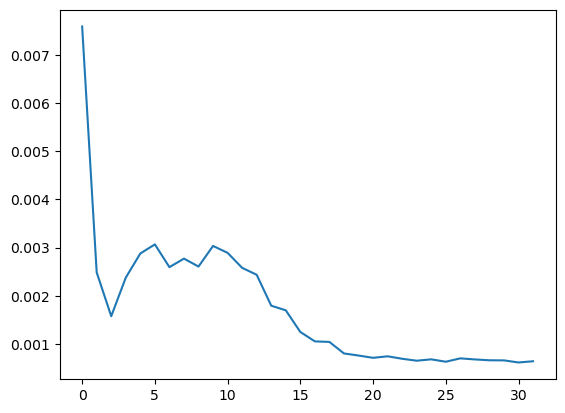

In [9]:
# Plot the loss history
print('Generating the history loss plot')
lineplot = sns.lineplot(x=history.epoch, y=history.history['loss'])
fig = lineplot.get_figure()
loss_fig_file = os.path.join(path, 'outputs/' + expname + '_loss.png')
fig.savefig(loss_fig_file) 

In [10]:
# Model performance on the whole training data
train_loss = model.evaluate(input_train, output_train)
print("Training Mean Squared Error:", train_loss)

76/76 [==============================] - 0s 3ms/step - loss: 5.8959e-04
Training Mean Squared Error: 0.0005895874346606433


In [11]:
# Model performance on testing data (unseen)
val_loss = model.evaluate(input_test, output_test)
print("Validation  Mean Squared Error:", val_loss)

19/19 [==============================] - 0s 3ms/step - loss: 6.6169e-04
Validation  Mean Squared Error: 0.0006616897881031036


In [12]:
# Save model
model_file = os.path.join(path, 'outputs/' + expname + '.h5')
model.save(model_file)

In [13]:
# Perform a prediction
print('Forecasting', input_test.sum())
output_test_forecast = model.predict(input_test)

Forecasting Lichen_mean      33.999845
t2m_0           590.882329
t2m_1           590.691313
t2m_2           590.546263
t2m_3           590.403796
                  ...     
tp_8755        1015.074581
tp_8756        1061.790653
tp_8757        1105.752405
tp_8758        1145.710408
tp_8759        1184.851913
Length: 17521, dtype: float64
19/19 [==============================] - 0s 3ms/step


In [14]:
output_test_forecast = pd.DataFrame(output_test_forecast.tolist())

In [15]:
output_test_forecast.columns = ['Forecasted_lichen']

In [16]:
output_test = output_test.reset_index().drop(columns=['index'])

In [17]:
output_test.columns = ['Actual_lichen']

In [57]:
# Calculate the cover
C_actual = (No_test.values * output_test['Actual_lichen'].values) * 100 * 100 / 1e06
C_forecast = (No_test.transpose().values * output_test_forecast['Forecasted_lichen'].values) * 100 * 100 / 1e06
TC_actual = C_actual.sum() 
TC_forecast = C_forecast.sum()
print('Total cover [in km2] = ', TC_forecast, ' (vs. ', TC_actual, ' actual)')
print('Total cover difference between actual and forecast [in %] = ', (((TC_actual - TC_forecast) / TC_actual * 100) * 100).astype('int') / 100)

Total cover [in km2] =  78.22763473334723  (vs.  87.92147384310823  actual)
Total cover difference between actual and forecast [in %] =  11.02


In [18]:
# Obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(output_test['Actual_lichen'], output_test_forecast['Forecasted_lichen'], 1)

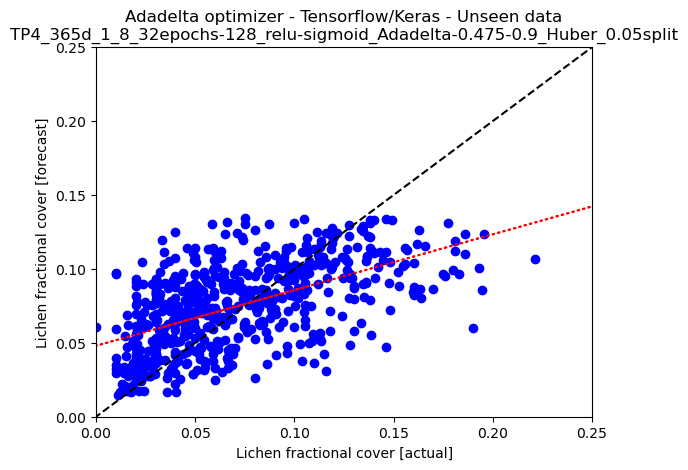

In [19]:
# Forecast vs. actual Values xy-plot - Unseen data

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(output_test, output_test_forecast, marker = 'o', c = 'blue')
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')
plt.plot(output_test['Actual_lichen'], m * output_test['Actual_lichen'] + b, color = 'red', ls = 'dotted')

plt.ylabel('Lichen fractional cover [forecast]')
plt.xlabel('Lichen fractional cover [actual]')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.ylim(0., 0.25)
plt.xlim(0., 0.25)

plt.axis(True)
plt.show()

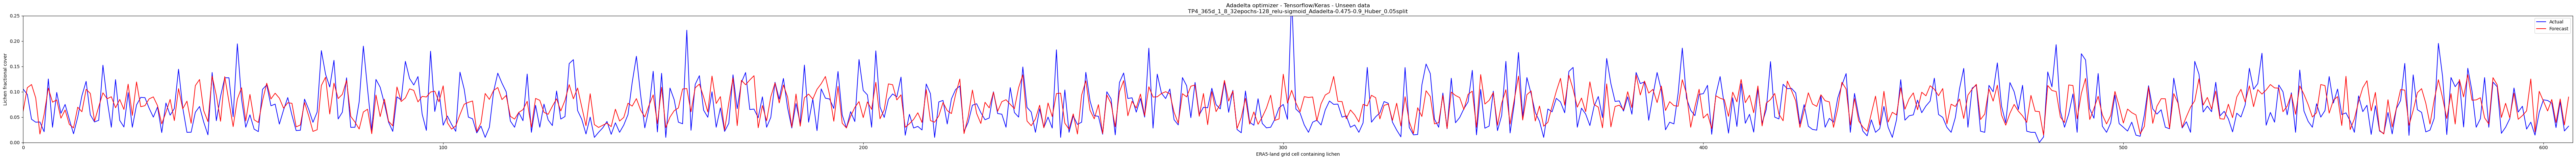

In [20]:
# Forecast vs. actual Values linear-plot - Unseen data

fig = plt.figure(figsize=(100, 5))
ax = fig.add_subplot(111)

plt.plot(output_test, c = 'blue')
plt.plot(output_test_forecast, c = 'red')

plt.ylabel('Lichen fractional cover')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(output_test))
plt.ylim(0., 0.25)
ax.legend(['Actual', 'Forecast'])

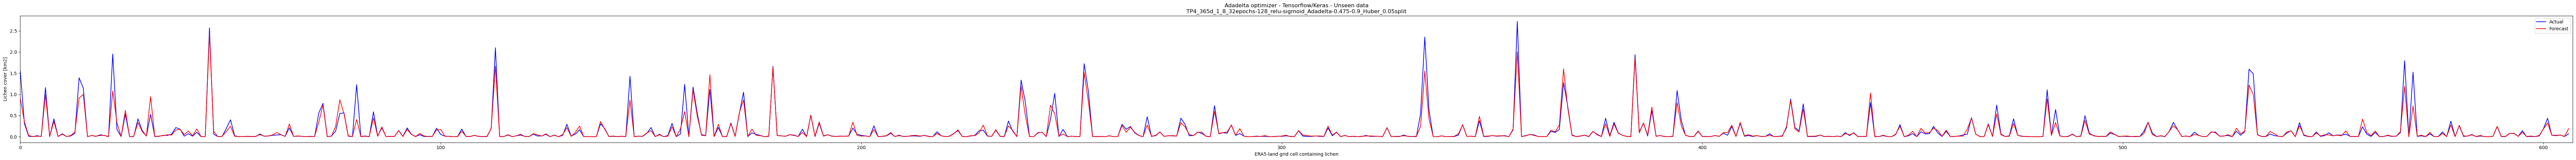

In [62]:
# Forecast vs. actual cover linear-plot - Unseen data

fig = plt.figure(figsize=(100, 5))
ax = fig.add_subplot(111)

plt.plot(C_actual, c = 'blue')
plt.plot(C_forecast, c = 'red')

plt.ylabel('Lichen cover [km2]')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(C_actual))
ax.legend(['Actual', 'Forecast'])